# Introduction to natural language processing (NLP) | Sentiment analysis

## Download and explore the IMDB dataset

In [ ]:
import tensorflow as tf
import os

In [ ]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", 
                                  url,
                                  untar=True, 
                                  cache_dir='.',
                                  cache_subdir='')

84131840/84125825 [==============================] - 2s 0us/step


Joining directories

In [ ]:
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

Let's take a look aclImdb folder

In [ ]:
os.listdir('aclImdb')

['train', 'imdb.vocab', 'test', 'README', 'imdbEr.txt']

Let's take a look train folder

In [ ]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'urls_neg.txt',
 'neg',
 'urls_unsup.txt',
 'unsupBow.feat',
 'pos',
 'unsup',
 'urls_pos.txt']

Let's take a look into a sample

In [ ]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
    print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Loading the dataset
First of all, let's remove unsup folder

In [ ]:
import shutil
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Let's create train set.

In [ ]:
batch_size = 32
seed = 42
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Let's take a look a sample in train set.

In [ ]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [ ]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Let's create validation set.

In [ ]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Let's create test set.

In [ ]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Data Preprocessing

Let's create custom function to remove HTML tags and punctuation.

In [ ]:
import re
import string

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(
      stripped_html, '[%s]' % re.escape(string.punctuation), '')

Let's create TextVectorization layer.

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
  standardize=custom_standardization,
  max_tokens=max_features,
  output_mode='int',
  output_sequence_length=sequence_length)

Let's make a text-only dataset (without labels), then call adapt

In [ ]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [ ]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

Let's retrieve a batch (of 32 reviews and labels) from the dataset

In [ ]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

Let's take a look some values

In [ ]:
print("128 ---> ",vectorize_layer.get_vocabulary()[128])
print("1312 ---> ",vectorize_layer.get_vocabulary()[1312])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

128 --->  here
1312 --->  thus
Vocabulary size: 10000


Let's map all datasets to vectorize_text

In [ ]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

Let's configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [ ]:
from tensorflow.keras import layers

embedding_dim = 16
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

Let's take a look summary the model.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


### Compiling the model

In [ ]:
from tensorflow.keras import losses
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Training the model

In [ ]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 12s 18ms/step - loss: 0.6841 - binary_accuracy: 0.6128 - val_loss: 0.6190 - val_binary_accuracy: 0.7664
Epoch 2/10
625/625 [==============================] - 4s 7ms/step - loss: 0.5835 - binary_accuracy: 0.7794 - val_loss: 0.5009 - val_binary_accuracy: 0.8214
Epoch 3/10
625/625 [==============================] - 4s 7ms/step - loss: 0.4682 - binary_accuracy: 0.8344 - val_loss: 0.4216 - val_binary_accuracy: 0.8462
Epoch 4/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3919 - binary_accuracy: 0.8603 - val_loss: 0.3745 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3447 - binary_accuracy: 0.8758 - val_loss: 0.3457 - val_binary_accuracy: 0.8670
Epoch 6/10
625/625 [==============================] - 4s 7ms/step - loss: 0.3113 - binary_accuracy: 0.8887 - val_loss: 0.3268 - val_binary_accuracy: 0.8716
Epoch 7/10
625/625 [==============================] - 4s 7ms/s

## Evaluating the model

In [ ]:
loss, accuracy = model.evaluate(test_ds)
print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 11s 13ms/step - loss: 0.3106 - binary_accuracy: 0.8732
Loss:  0.31062832474708557
Accuracy:  0.873199999332428


## Create a plot of accuracy and loss over time

In [ ]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [ ]:
import matplotlib.pyplot as plt
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

Let's take a look the plot of training and validation loss

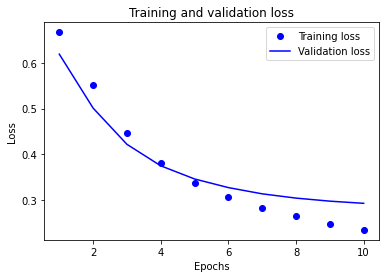

In [ ]:
epochs = range(1, len(acc) + 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Let's take a look the plot of training and validation accuracy

In [ ]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

## Exporting the model

In [ ]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy'])

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 11s 14ms/step - loss: 0.3115 - accuracy: 0.8733
0.873199999332428


## Predicting new data

In [ ]:
examples = [
  "The movie was perfect!",
  "The movie was okay.",
  "The movie was awful..."
]

In [ ]:
export_model.predict(examples)

array([[0.6124195 ],
       [0.43407172],
       [0.3165577 ]], dtype=float32)

That's all. Thank you for reading. Don't forget to follow on [Tirendaz Academy YouTube](https://www.youtube.com/tirendazakademi), [Twitter](https://twitter.com/TirendazAcademy), [Medium](https://tirendazacademy.medium.com), [GitHub](https://github.com/TirendazAcademy) and [LinkedIn](https://www.linkedin.com/in/tirendaz-academy)